<a href="https://colab.research.google.com/github/CorsiDanilo/big-data-computing-project/blob/main/BDC_Project_Bitcoin_price_forecasting_(Evaluation_%2B_conclusions).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bitcoin price forecasting with PySpark
## Big Data Computing final project - A.Y. 2022 - 2023
Prof. Gabriele Tolomei

MSc in Computer Science

La Sapienza, University of Rome

### Author
Corsi Danilo - corsi.1742375@studenti.uniroma1.it



### Introduction

The cryptocurrency Bitcoin has attracted the attention of many people in recent years. However, it's
price fluctuation can be extremely unpredictable, which makes it difficult to predict when the right
time to buy or sell this digital currency will be. In this context, forecasting Bitcoin prices can be a
competitive advantage for investors and traders, as it could allow them to make informed decisions
on the right time to enter or exit the market. In this project, I will analyze some machine learning
techniques to understand, through the processing of historical data, how accurately the price of Bitcoin
can be predicted and whether this can provide added value to cryptocurrency investors and traders.
### Dataset
I chose to use the following dataset from Kaggle Bitcoin Historical Dataset, more specifically those
containing minute-by-minute updates of the Bitcoin price from 2017 to 2021 (period for which there
were moments of high volatility but also a lot of price lateralisation). The columns (features) contained
in it, in addition to the timestamp of each transaction, are the opening, closing, highest and lowest
price and the corresponding trading volume in Bitcoin and Dollars.
### Methods (TODO: da scegliere per bene)
The methods I will test will be Linear Regression (simple and multiple) and Random Forest. Further
comparisons with other classification models are planned in the course of development. Moreover, I
would also like to try to understand what the differences are between these methods and the imple-
mentation of a state-of-the-art neural network such as Long-Short Term Memory.
### Evaluation framework (TODO: vedi quali usare in base ai paper/esempi e ai modelli utilizzati)
As evaluation framework I will use R-square (R²), Mean Square Error (MSE) and Mean Absolute
Error (MAE) to get a complete picture of the performance of the various models.

# **Spark + Google Colab Setup**

## Global Constants


In [ ]:
JAVA_HOME = "/usr/lib/jvm/java-8-openjdk-amd64"
GDRIVE_DIR = "/content/drive"
GDRIVE_DATASET_DIR = GDRIVE_DIR + "/MyDrive/Computer_Science/BDC/project/datasets"
# GDRIVE_DATASET = GDRIVE_DATASET_DIR + "/BTC-2017_2021.csv"
# GDRIVE_DATASET = GDRIVE_DATASET_DIR + "/BTC-2017_2021_1000000.csv"
# GDRIVE_DATASET = GDRIVE_DATASET_DIR + "/BTC-2017_2021_500000.csv"
GDRIVE_DATASET = GDRIVE_DATASET_DIR + "/BTC-2015_2023.csv"

## Install PySpark and related dependencies





In [ ]:
!pip install pyspark
# Alternatively, if you want to install a specific version of pyspark:
#!pip install pyspark==3.2.1
!pip install -U -q PyDrive # To use files that are stored in Google Drive directly (e.g., without downloading them from an external URL)
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = JAVA_HOME


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=4668b3f4aa3d6c27ca3d53790303303f892d8cad62bc9156b4d24d7cac59bbf5
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 36.5 MB of archives.
After this operatio

## Install Koalas and related dependencies

In [ ]:
!pip install koalas
!pip install hyper

import collections.abc
# hyper needs the four following aliases to be done manually.
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping
collections.Callable = collections.abc.Callable
# now import hyper
import hyper

import databricks.koalas as ks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 593.2/593.2 kB 14.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.8/269.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 8.3 MB/s eta 0:00:00


##  Import useful Python packages

In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

from itertools import cycle

import plotly.express as px

from pyspark.sql import functions as F

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import gc

## Define useful functions


In [ ]:
# free memory
def free_memory(x):
  del x
  gc.collect()

# TODO: solo per testare piú velocemente le cose
def import_df():
  # GDRIVE_DATASET = GDRIVE_DATASET_DIR + "/BTC-2017_2021.csv"
  # GDRIVE_DATASET = GDRIVE_DATASET_DIR + "/BTC-2017_2021_1000000.csv"
  # GDRIVE_DATASET = GDRIVE_DATASET_DIR + "/BTC-2017_2021_500000.csv"
  # GDRIVE_DATASET = GDRIVE_DATASET_DIR + "/BTC-2017_2021_250000.csv"
  GDRIVE_DATASET = GDRIVE_DATASET_DIR + "/BTC-2015_2023.csv"

  df = spark.read.load(GDRIVE_DATASET, 
                        format="csv", 
                        sep=",", 
                        inferSchema="true", 
                        header="true"
                        )
  
  df = df.withColumnRenamed("Volume BTC","volume_btc") \
      .withColumnRenamed("Volume USD","volume_usd") \
      .drop("symbol") \
      .drop("unix")

  df = df.drop("high") \
  .drop("low") \
  .drop("open") \
  .drop("volume_btc") \
  .drop("volume_usd")

  return df.to_koalas()

##  Create Spark context

In [ ]:
# Create the session
conf = SparkConf().\
                set('spark.ui.port', "4050").\
                set('spark.executor.memory', '4G').\
                set('spark.driver.memory', '45G').\
                set('spark.driver.maxResultSize', '10G').\
                setAppName("BitcoinPriceForecasting").\
                setMaster("local[*]")

# Create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

##  Create <code>ngrok</code> tunnel to check the Spark UI

In [ ]:
# Install ngrok
!pip install pyngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-6.0.0-py3-none-any.whl size=19867 sha256=a291984178611f5ce16cf009067f04ce2eeaf8b71237e6acd9a673ebbecbff23
  Stored in directory: /root/.cache/pip/wheels/5c/42/78/0c3d438d7f5730451a25f7ac6cbf4391759d22a67576ed7c2c
Successfully built pyngrok


In [ ]:
# Saving authtoken 
!ngrok authtoken 2PKOO1E6Ghw65dpEG4QNSVzu9PY_GufsrTiussGmBxF664RD 

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
from pyngrok import ngrok

# Open a ngrok tunnel on the port 4050 where Spark is running
port = '4050'
public_url = ngrok.connect(port).public_url

In [ ]:
print("To access the Spark Web UI console, please click on the following link to the ngrok tunnel \"{}\" -> \"http://127.0.0.1:{}\"".format(public_url, port))

To access the Spark Web UI console, please click on the following link to the ngrok tunnel "https://3eb2-34-125-3-18.ngrok-free.app" -> "http://127.0.0.1:4050"


##  Link Colab to our Google Drive

In [ ]:
# Point Colaboratory to our Google Drive

from google.colab import drive

drive.mount(GDRIVE_DIR, force_remount=True)

Mounted at /content/drive


##  Check everything is ok

In [ ]:
spark

In [ ]:
sc._conf.getAll()

[('spark.driver.port', '34501'),
 ('spark.app.startTime', '1685990412098'),
 ('spark.driver.memory', '45G'),
 ('spark.executor.id', 'driver'),
 ('spark.sql.warehouse.dir', 'file:/content/spark-warehouse'),
 ('spark.driver.maxResultSize', '10G'),
 ('spark.app.name', 'BitcoinPriceForecasting'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.b

# **Dataset, processing and feature extraction**

In this section we are going to explore the dataset, to clean it from null values, and to determine which features are relevant and which are not.

##  Data cleaning

First, we import the dataset from Google Drive.

In [ ]:
# load dataset into pyspark dataframe objects
# df = spark.read.load(GDRIVE_DATASET, 
#                          format="csv", 
#                          sep=",", 
#                          inferSchema="true", 
#                          header="true"
#                          )

# load dataset into koalas dataframe objects
df = ks.read_csv(GDRIVE_DATASET)

Check the shape of the loaded dataset, print out the schema of the loaded dataset.

In [ ]:
def show_dataset(dataframe: Union[DataFrame, ks.DataFrame]) -> None:
  if isinstance(dataframe, ks.DataFrame): dataframe = dataframe.to_spark()
  
  print("The shape of the dataset is {:d} rows by {:d} columns".format(dataframe.count(), len(dataframe.columns)))
  dataframe.printSchema()
  dataframe.show(5)	

In [ ]:
show_dataset(df)

The shape of the dataset is 3766763 rows by 9 columns
root
 |-- Timestamp: long (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Symbol: string (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume BTC: double (nullable = true)
 |-- Volume USD: double (nullable = true)

+-------------+-------------------+-------+--------+--------+--------+--------+----------+---------------+
|    Timestamp|               Date| Symbol|    Open|    High|     Low|   Close|Volume BTC|     Volume USD|
+-------------+-------------------+-------+--------+--------+--------+--------+----------+---------------+
|1676939580000|2023-02-21 00:33:00|BTC/USD|24859.34|24859.34|24859.34|24859.34|       0.0|            0.0|
|1676939520000|2023-02-21 00:32:00|BTC/USD|24821.96|24859.34|24821.96|24859.34|0.10309919|2562.9778179346|
|1676939460000|2023-02-21 00:31:00|BTC/USD|24818.09|24821.96|

The dataset contains **2675301** records of bitcoin historical data from 2017 to 2021; each record, contains the following set of **9** columns:

* Unix Timestamp - This is the unix timestamp or also known as "Epoch Time";
* Date - This timestamp is UTC Timezone;
* Symbol - The symbol for which the timeseries data refers;
* Open - This is the opening price of the time period;
* High - This is the highest price of the time period;
* Low - This is the lowest price of the time period;
* Close - This is the closing price of the time period;
* Volume (Crypto) - This is the volume in the transacted Ccy. Ie. For BTC/USDT, this is in BTC amount;
* Volume Base Ccy - This is the volume in the base/converted ccy. Ie. For BTC/USDT, this is in USDT amount;

We can delete the "symbol" and "unix" columns since we are not gonna use it and changing the name of "Volume BTC" and "Volume USD", check how many Nan values we have in the dataset and reduce the columns in the DataFrame to two decimal places except for the btc volume.


In [ ]:
def prepare_dataset(dataframe: Union[DataFrame, ks.DataFrame]) -> None:
  if isinstance(dataframe, ks.DataFrame): dataframe = dataframe.to_spark()

  # Here we can delete the "symbol" and "unix" columns since we are not gonna use it and changing the name of "Volume BTC" and "Volume USD"
  dataframe = dataframe.withColumnRenamed("Date","date") \
    .withColumnRenamed("Volume BTC","volume_btc") \
    .withColumnRenamed("Volume USD","volume_usd") \
    .drop("symbol") \
    .drop("unix")

  # Here, we can check how many Nan values we have in the dataset.
  for c in dataframe.columns:
    print("N. of missing values of column `{:s}` = {:d}".format(c, dataframe.where(col(c).isNull()).count()))

  # Here we reduce the columns in the DataFrame to two decimal places except for the volume in bitcoin.
  dataframe = dataframe.withColumn("open", round(dataframe["open"], 2)) \
                  .withColumn("close", round(dataframe["close"], 2)) \
                  .withColumn("high", round(dataframe["high"], 2)) \
                  .withColumn("low", round(dataframe["low"], 2)) \
                  .withColumn("volume_usd", round(dataframe["volume_usd"], 2)
                )
                  
  dataframe.show(5)	

  return dataframe               

In [ ]:
df = prepare_dataset(df)

N. of missing values of column `Timestamp` = 0
N. of missing values of column `date` = 0
N. of missing values of column `open` = 0
N. of missing values of column `high` = 0
N. of missing values of column `low` = 0
N. of missing values of column `close` = 0
N. of missing values of column `volume_btc` = 0
N. of missing values of column `volume_usd` = 0
+-------------+-------------------+--------+--------+--------+--------+----------+----------+
|    Timestamp|               date|    open|    high|     low|   close|volume_btc|volume_usd|
+-------------+-------------------+--------+--------+--------+--------+----------+----------+
|1676939580000|2023-02-21 00:33:00|24859.34|24859.34|24859.34|24859.34|       0.0|       0.0|
|1676939520000|2023-02-21 00:32:00|24821.96|24859.34|24821.96|24859.34|0.10309919|   2562.98|
|1676939460000|2023-02-21 00:31:00|24818.09|24821.96|24815.47|24821.96|0.09064015|   2249.87|
|1676939400000|2023-02-21 00:30:00|24812.25|24818.09|24812.25|24818.09|0.00220329| 

[Row(Timestamp=1676939580000, date=datetime.datetime(2023, 2, 21, 0, 33), open=24859.34, high=24859.34, low=24859.34, close=24859.34, volume_btc=0.0, volume_usd=0.0),
 Row(Timestamp=1676939520000, date=datetime.datetime(2023, 2, 21, 0, 32), open=24821.96, high=24859.34, low=24821.96, close=24859.34, volume_btc=0.10309919, volume_usd=2562.98),
 Row(Timestamp=1676939460000, date=datetime.datetime(2023, 2, 21, 0, 31), open=24818.09, high=24821.96, low=24815.47, close=24821.96, volume_btc=0.09064015, volume_usd=2249.87),
 Row(Timestamp=1676939400000, date=datetime.datetime(2023, 2, 21, 0, 30), open=24812.25, high=24818.09, low=24812.25, close=24818.09, volume_btc=0.00220329, volume_usd=54.68),
 Row(Timestamp=1676939340000, date=datetime.datetime(2023, 2, 21, 0, 29), open=24809.27, high=24812.25, low=24809.27, close=24812.25, volume_btc=0.09067547, volume_usd=2249.86)]

##  Exploring the data
Now, before building a model to predict the Bitcoin price, let's try a have a better visualization of the data.

In [ ]:
def historical_bitcoin_prices(dataframe):
  # We use Plotly to create the plots https://plot.ly/python/
  trace1 = go.Scatter(
      x = dataframe['date'],
      y = dataframe['avg_open'].astype(float),
      mode = 'lines',
      name = 'Open'
  )

  trace2 = go.Scatter(
      x = dataframe['date'],
      y = dataframe['avg_close'].astype(float),
      mode = 'lines',
      name = 'Close'
  )
  trace3 = go.Scatter(
      x = dataframe['date'],
      y = dataframe['avg_high'].astype(float),
      mode = 'lines',
      name = 'High'
  )
  trace4 = go.Scatter(
      x = dataframe['date'],
      y = dataframe['avg_low'].astype(float),
      mode = 'lines',
      name = 'Low'
  )

  layout = dict(
      title='Historical Bitcoin Prices (2017 - 2021) with the Slider ',
      xaxis=dict(
          rangeselector=dict(
              buttons=list([
                  #change the count to desired amount of months.
                  dict(count=1,
                      label='1m',
                      step='month',
                      stepmode='backward'),
                  dict(count=6,
                      label='6m',
                      step='month',
                      stepmode='backward'),
                  dict(count=12,
                      label='1y',
                      step='month',
                      stepmode='backward'),
                  dict(count=36,
                      label='3y',
                      step='month',
                      stepmode='backward'),
                  dict(step='all')
              ])
          ),
          rangeslider=dict(
              visible = True
          ),
          type='date'
      )
  )

  data = [trace1,trace2, trace3, trace4]
  fig = dict(data=data, layout=layout)
  iplot(fig, filename = "Time Series with Rangeslider")

In [ ]:
def historical_bitcoin_volume(dataframe):
  trace1 = go.Scatter(
      x = dataframe['date'],
      y = dataframe['avg_volume_usd'].astype(float),
      mode = 'lines',
      name = 'Bitcoin Price (Open)'
  )

  layout = dict(
      title='Historical Bitcoin Volume (USD) (2017 - 2021) with the slider',
      xaxis=dict(
          rangeselector=dict(
              buttons=list([
                  dict(count=1,
                      label='1m',
                      step='month',
                      stepmode='backward'),
                  dict(count=6,
                      label='6m',
                      step='month',
                      stepmode='backward'),
                  dict(count=12,
                      label='1y',
                      step='month',
                      stepmode='backward'),
                  dict(count=36,
                      label='3y',
                      step='month',
                      stepmode='backward'),
                  dict(step='all')
              ])
          ),
          rangeslider=dict(
              visible = True
          ),
          type='date'
      )
  )

  data = [trace1]
  fig = dict(data=data, layout=layout)
  iplot(fig, filename = "Time Series with Rangeslider")

In [ ]:
#BTC Volume vs Price USD visualization
def btc_volume_vs_price_usd(dataframe):
  trace = go.Scattergl(
      y = dataframe['avg_volume_btc'].astype(float),
      x = dataframe['avg_close'].astype(float),
      mode = 'markers',
      marker = dict(
          color = '#FFBAD2',
          line = dict(width = 1)
      )
  )
  layout = go.Layout(
      title='BTC Volume v/s USD',
      xaxis=dict(
          title='Close Price',
          titlefont=dict(
              family='Courier New, monospace',
              size=18,
              color='#7f7f7f'
          )
      ),
      yaxis=dict(
          title='Volume BTC',
          titlefont=dict(
              family='Courier New, monospace',
              size=18,
              color='#7f7f7f'
          )))
  data = [trace]
  fig = go.Figure(data=data, layout=layout)
  iplot(fig, filename='compare_volume_btc_close_price')

In [ ]:
def compute_avg_df(dataframe: Union[DataFrame, ks.DataFrame]) -> None:
  if isinstance(dataframe, ks.DataFrame): dataframe = dataframe.to_spark()

  # Calculation of the average price and volume for each day
  avg_df = dataframe.withColumn("date", date_format(dataframe.date, "yyyy-MM-dd")).groupBy("date").agg(
      avg("open").alias("avg_open"),
      avg("close").alias("avg_close"),
      avg("high").alias("avg_high"),
      avg("low").alias("avg_low"),
      avg("volume_btc").alias("avg_volume_btc"),
      avg("volume_usd").alias("avg_volume_usd")
  ).sort("date")

  # Reduce the columns in the DataFrame to two decimal places
  avg_df = avg_df.withColumn("avg_open", round(avg_df["avg_open"], 2)) \
                      .withColumn("avg_close", round(avg_df["avg_close"], 2)) \
                      .withColumn("avg_high", round(avg_df["avg_high"], 2)) \
                      .withColumn("avg_low", round(avg_df["avg_low"], 2)) \
                      .withColumn("avg_volume_usd", round(avg_df["avg_volume_usd"], 2)
                      )

  print("The shape of the dataset is {:d} rows by {:d} columns".format(avg_df.count(), len(avg_df.columns)))
  avg_df.show(5)

  # convert the dataframe from PySpark to Pandas
  return avg_df.toPandas()

In [ ]:
avg_df_pandas = compute_avg_df(df)

The shape of the dataset is 2663 rows by 7 columns
+----------+--------+---------+--------+-------+--------------------+--------------+
|      date|avg_open|avg_close|avg_high|avg_low|      avg_volume_btc|avg_volume_usd|
+----------+--------+---------+--------+-------+--------------------+--------------+
|2015-10-08|   243.9|    244.3|   244.3| 243.89|0.051217262260000014|         12.52|
|2015-10-09|  244.04|   244.04|  244.04| 244.03| 0.03890822275583334|          9.64|
|2015-10-10|  245.36|   245.36|  245.36| 245.36|0.027325539787777773|           6.7|
|2015-10-11|  246.88|   246.88|  246.88| 246.88|0.010060960377152778|          2.49|
|2015-10-12|  248.24|   248.24|  248.24| 248.24| 0.04360241661805555|         10.81|
+----------+--------+---------+--------+-------+--------------------+--------------+
only showing top 5 rows



In [ ]:
historical_bitcoin_prices(avg_df_pandas)

In [ ]:
# df = import_df().to_spark()

In [ ]:
# df.show(5)

+-------------+-------------------+--------+
|    Timestamp|               Date|   Close|
+-------------+-------------------+--------+
|1676939580000|2023-02-21 00:33:00|24859.34|
|1676939520000|2023-02-21 00:32:00|24859.34|
|1676939460000|2023-02-21 00:31:00|24821.96|
|1676939400000|2023-02-21 00:30:00|24818.09|
|1676939340000|2023-02-21 00:29:00|24812.25|
+-------------+-------------------+--------+
only showing top 5 rows



In [ ]:
# start_date = '12/20/2020 7:53:00'
# end_date = '11/23/2020 12:36:00'

# filtered_df = df.filter((col('date') >= start_date) & (col('date') <= end_date))

# filtered_df.show(5)

+---------+----+-----+
|Timestamp|Date|Close|
+---------+----+-----+
+---------+----+-----+



In [ ]:
# # TODO: vedere come sistemare il fatto che ci sono valori mancanti dal 23 novembre del 2020 al 20 dicembre del 2020
# from datetime import datetime
# from pyspark.sql.functions import col

# # Date di inizio e fine dell'intervallo desiderato
# start_date = '12/20/2020 7:53:00'
# end_date = '11/23/2020 12:36:00'
# min_value = 18247.67
# max_value = 23573.41

# # Crea un intervallo di date con un minuto di frequenza
# date_range = pd.date_range(start=start_date, end=end_date, freq='1min')

# # Genera i valori del prezzo di chiusura in scala tra il valore minimo e massimo
# price_values = pd.Series(np.linspace(min_value, max_value, len(date_range)))

# # Crea il DataFrame con le colonne "data" e "prezzo di chiusura"
# df_missing = pd.DataFrame({'date': date_range, 'close': price_values})

# print(df_missing)

Empty DataFrame
Columns: [date, close]
Index: []


In [ ]:
historical_bitcoin_volume(avg_df_pandas)

In [ ]:
btc_volume_vs_price_usd(avg_df_pandas)

##  Feature Selection

The aim of this section is to remove the features that have less of an impact to the final result from the dataframe. This operation is called feature selection. Let's plot a correlation map to see how features are correlated among each other:

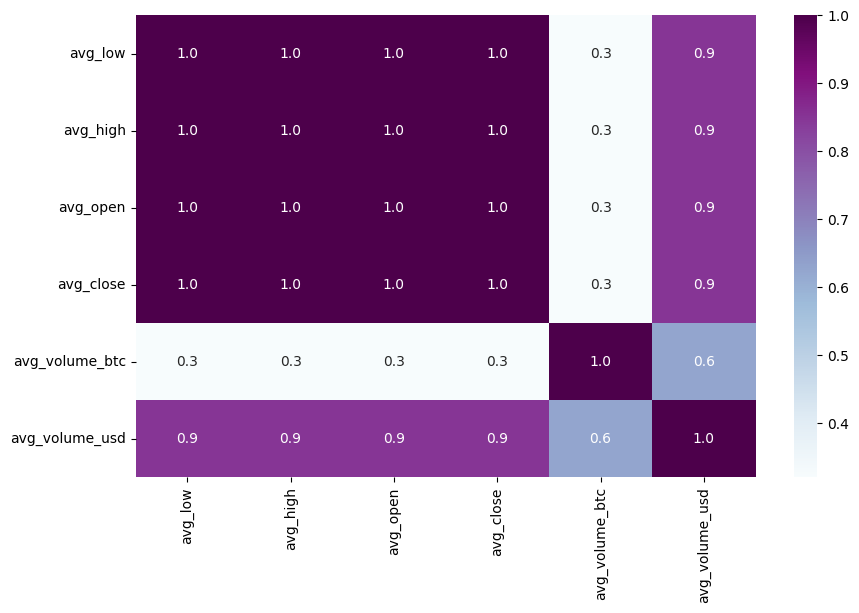

In [ ]:
import seaborn as sns
# plotting correlation heatmap
plt.figure(figsize = (10, 6))
dataplot = sns.heatmap(avg_df_pandas[['avg_low','avg_high','avg_open','avg_close', 'avg_volume_btc', 'avg_volume_usd']].corr(), cmap="BuPu", annot=True, 
                      fmt=".1f")
plt.show()

Here we can observe that, the high, low, open and close are the almost correlate features, so for price forecasting, we can drop all of them from the origial dataset except for the closing price. Also we can drop volume_btc and volume_usd since we are not gonna use it. 

Selected Features
- Close Price

In [ ]:
def feature_selection(dataframe: Union[DataFrame, ks.DataFrame]) -> None:
  if isinstance(dataframe, ks.DataFrame): dataframe = dataframe.to_spark()

  dataframe = dataframe.drop("high") \
        .drop("low") \
        .drop("open") \
        .drop("volume_btc") \
        .drop("volume_usd")

  dataframe.printSchema()
  dataframe.show(5)

  return dataframe

In [ ]:
df = feature_selection(df)

root
 |-- date: timestamp (nullable = true)
 |-- close: double (nullable = true)

+-------------------+--------+
|               date|   close|
+-------------------+--------+
|2017-12-31 23:59:00| 13880.0|
|2017-12-31 23:58:00|13953.77|
|2017-12-31 23:57:00|13913.26|
|2017-12-31 23:56:00|13859.58|
|2017-12-31 23:55:00|13825.05|
+-------------------+--------+
only showing top 5 rows



In [ ]:
# delete avg_df_pandas (Pandas) since we are not gonne use it anymore
free_memory(avg_df_pandas)

##  Model preparation ❗


Prepara i dati: Assicurati che il tuo dataset sia in un formato adatto per l'addestramento del modello. Dovresti avere una colonna di etichette di output (variabile di risposta) e le features (variabili indipendenti) in colonne separate.

Crea un VectorAssembler: Un VectorAssembler è utilizzato per combinare le features in una singola colonna vettoriale. Questo passaggio è necessario poiché PySpark richiede che le features siano in un unico vettore per l'addestramento del modello Random Forest.

In [ ]:
df = import_df()

In [ ]:
def model_preparation(dataframe: Union[DataFrame, ks.DataFrame]) -> None:
  if isinstance(dataframe, ks.DataFrame): dataframe = dataframe.to_spark()
  
  from pyspark.ml.feature import VectorAssembler

  assembler = VectorAssembler(
      inputCols=["close"],  # Colonna del prezzo di chiusura
      outputCol="features"  # Colonna vettoriale risultante
  )

  dataframe = assembler.transform(dataframe)

  from pyspark.sql.functions import date_format, to_timestamp

  # transform date column into string
  dataframe = dataframe.withColumn("date_str", date_format(to_timestamp("date", "yyyy-MM-dd HH:mm:ss"), "yyyy-MM-dd HH:mm:ss"))

 # encode the date to a column of label indicies
  from pyspark.ml.feature import StringIndexer

  label_stringIdx = StringIndexer(inputCol = 'date_str', outputCol = 'labelIndex')
  dataframe = label_stringIdx.fit(dataframe).transform(dataframe)

  # dividi il dataset in train set e test set
  from pyspark.sql.functions import percent_rank
  from pyspark.sql import Window

  dataframe = dataframe.withColumn("rank", percent_rank().over(Window.partitionBy().orderBy("date_str")))
  train_df = dataframe.where("rank <= .8").drop("rank", "date_str")
  test_df = dataframe.where("rank > .8").drop("rank", "date_str")

  # print("The shape of the train set is {:d} rows by {:d} columns".format(train_df.count(), len(train_df.columns)))
  # train_df.printSchema()
  # train_df.show(5)	

  # print("The shape of the test set is {:d} rows by {:d} columns".format(test_df.count(), len(test_df.columns)))
  # test_df.printSchema()
  # test_df.show(5)	

  return train_df.to_koalas(), test_df.to_koalas()

In [ ]:
train_df, test_df = model_preparation(df)

In [ ]:
def compute_avg_train_test(dataframe):
  dataframe = dataframe.to_spark()

  dataframe = dataframe.drop("features", "labelIndex")
  
  dataframe = dataframe.withColumn("date", date_format(dataframe.date, "yyyy-MM-dd")).groupBy("date").agg(
      avg("close").alias("avg_close")
  ).sort("date")

  dataframe = dataframe.withColumn("avg_close", round(dataframe["avg_close"], 2))

  return dataframe

In [ ]:
def show_avg_train_test(train_df, test_df):
  avg_train_df_pandas = compute_avg_train_test(train_df).toPandas()
  avg_test_df_pandas = compute_avg_train_test(test_df).toPandas()

  trace1 = go.Scatter(
      x = avg_train_df_pandas['date'],
      y = avg_train_df_pandas['avg_close'].astype(float),
      mode = 'lines',
      name = 'Train set'
  )

  trace2 = go.Scatter(
      x = avg_test_df_pandas['date'],
      y = avg_test_df_pandas['avg_close'].astype(float),
      mode = 'lines',
      name = 'Test set'
  )
  
  layout = dict(
      title='Train and Test set with the Slider ',
      xaxis=dict(
          rangeselector=dict(
              buttons=list([
                  #change the count to desired amount of months.
                  dict(count=1,
                      label='1m',
                      step='month',
                      stepmode='backward'),
                  dict(count=6,
                      label='6m',
                      step='month',
                      stepmode='backward'),
                  dict(count=12,
                      label='1y',
                      step='month',
                      stepmode='backward'),
                  dict(count=36,
                      label='3y',
                      step='month',
                      stepmode='backward'),
                  dict(step='all')
              ])
          ),
          rangeslider=dict(
              visible = True
          ),
          type='date'
      )
  )

  data = [trace1,trace2]
  fig = dict(data=data, layout=layout)
  iplot(fig, filename = "Train and Test set  with Rangeslider")

In [ ]:
show_avg_train_test(train_df, test_df)

# 4. Application of models

###  Random Forest ❗

https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.tree.RandomForest.html

In [ ]:
def random_forest(train_df, test_df):
  from pyspark.ml.regression import RandomForestRegressor
  
  #Crea un oggetto RandomForestRegressor: Puoi impostare i parametri desiderati per il modello Random Forest come numero di alberi (numTrees), profondità massima degli alberi (maxDepth), numero massimo di bin per il partizionamento delle features (maxBins), ecc.
  rf = RandomForestRegressor(
      featuresCol="features",  # Colonna vettoriale delle features
      labelCol="labelIndex",  # Colonna delle etichette di output
  )

  # Addestra il modello: Utilizza il metodo fit() per addestrare il modello sulla tua dataset di addestramento.
  model = rf.fit(train_df.to_spark())

  # Effettua le previsioni: Utilizza il modello addestrato per fare previsioni sul tuo dataset di test o su nuovi dati.
  predictions = model.transform(test_df.to_spark())

  return predictions

In [ ]:
predictions = random_forest(train_df, test_df)

TypeError: ignored

In [ ]:
def evaluation(predictions):
  from pyspark.ml.evaluation import RegressionEvaluator

  evaluator = RegressionEvaluator(
      labelCol="labelIndex",  # Colonna delle etichette di output
      predictionCol="prediction"  # Colonna delle previsioni
  )

  mse = evaluator.evaluate(predictions, {evaluator.metricName: "mse"})
  rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
  r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
  mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})

  from pyspark.sql.functions import abs, col
  from pyspark.sql import functions as F
  from pyspark.ml.evaluation import RegressionEvaluator

  # Calcola il MAPE
  mape = predictions.withColumn("error", abs(col("labelIndex") - col("prediction")) / col("labelIndex")) \
          .selectExpr("avg(error) * 100 as mape") \
          .collect()[0]["mape"]
          
  # adj_r2 
  n = predictions.count()  # Numero di osservazioni
  p = 1  # Numero di predittori nel modello
  adj_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))

  print("MSE = %s" % (mse)) # deve essere un valore non negativo, dove un valore di 0 indica una perfetta corrispondenza tra i valori predetti e quelli di riferimento
  print("RMSE = %s" % (rmse)) # dovresti considerare il valore di RMSE in relazione al range dei valori target nel tuo problema specifico
  print("R2 = %s" % (r2)) # piú é vicino ad 1 meglio é
  print("MAE = %s" % (mae)) # può essere utile confrontare il valore di MAE con quello di altri modelli o con il range dei valori target per valutare la sua precisione
  print("MAPE = %s" % (mape)) # di solito viene utilizzato come misura relativa per confrontare la precisione di modelli diversi
  print("ADJ R2 = %s" % (adj_r2)) # piú é vicino ad 1 meglio é

In [ ]:
evaluation(predictions)

MSE = 4115570061.7058945
RMSE = 64152.70891946726
R2 = -3.9386840745409417
MAE = 57489.83288310369
MAPE = 0.12422628632539084
ADJ R2 = -3.938733462369444


###  XGBoost ❗

https://xgboost.readthedocs.io/en/stable/parameter.html#global-configuration

In [ ]:
def xgboost(train_df, test_df):
  !pip install xgboost

  from xgboost.spark import SparkXGBRegressor

  # Creazione dell'XGBoostRegressor
  xgboost = SparkXGBRegressor(
      features_col="features",  # Colonna vettoriale delle features
      label_col="labelIndex",  # Colonna delle etichette di output
  )
  
  # Addestra il modello: Utilizza il metodo fit() per addestrare il modello sulla tua dataset di addestramento.
  model = xgboost.fit(train_df.to_spark())

  # Effettua le previsioni: Utilizza il modello addestrato per fare previsioni sul tuo dataset di test o su nuovi dati.
  predictions = model.transform(test_df.to_spark())

  return predictions

In [ ]:
predictions = xgboost(train_df, test_df)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
evaluation(predictions)

###  LSTM ❗

In the first section, we use LSTM (Long short-term memory ). LSTM units are units of a recurrent neural network (RNN). An RNN composed of LSTM units is often called an LSTM network (or just LSTM). A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell. Read more about LSTMs here.

Though LSTM is not ideal for forecasting turbulent market like Bitcoin but we still take a chance here.

In [ ]:
train_df.drop("features") \
  .drop("labelIndex") \
  .printSchema()

test_df.drop("features") \
  .drop("labelIndex") \
  .printSchema()

# USANDO KOALAS

# train_df_koalas = train_df.to_koalas()
# test_df_koalas = test_df.to_koalas()

# print("Training Dataset Count: " + str(train_df_koalas.shape[0]))
# print("Test Dataset Count: " + str(test_df_koalas.shape[0]))

# data_train = train_df_koalas
# data_test = test_df_koalas

# ------------------

# USANDO PANDAS

train_df_pandas = train_df.toPandas()
test_df_pandas = test_df.toPandas()

print("Training Dataset Count: " + str(train_df_pandas.shape[0]))
print("Test Dataset Count: " + str(test_df_pandas.shape[0]))

data_train = train_df_pandas
data_test = test_df_pandas

root
 |-- date: string (nullable = true)
 |-- close: double (nullable = true)

root
 |-- date: string (nullable = true)
 |-- close: double (nullable = true)



KeyboardInterrupt: ignored

In [ ]:
# data['date'] = data['date'].dt.tz_localize(None)
# data = data.groupby([pd.Grouper(key='date', freq='H')]).first().reset_index()
# data = data.set_index('date')
# data = data[['close']]
# data['close'].fillna(method='ffill', inplace=True)

In [ ]:
# # split data
# split_date = '20-Jul-2021'
# data_train = data.loc[data.index <= split_date].copy()
# data_test = data.loc[data.index > split_date].copy()

In [ ]:
# Data preprocess
training_set = data_train.values
training_set = np.reshape(training_set, (len(training_set), 1))

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))

KeyboardInterrupt: ignored

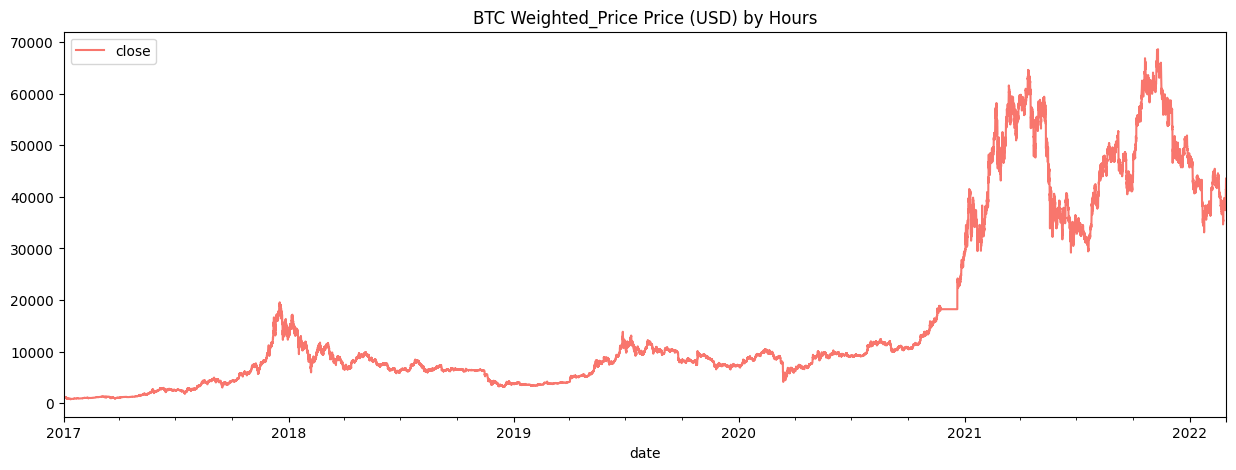

In [ ]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = data.plot(style='', figsize=(15,5), color=color_pal[0], title='BTC Weighted_Price Price (USD) by Hours')

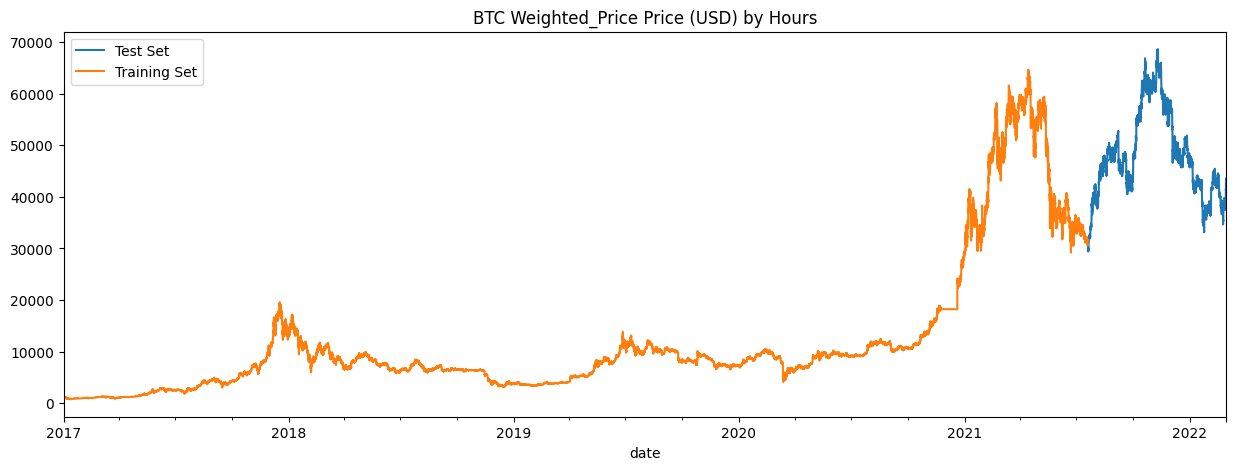

In [ ]:
_ = data_test \
    .rename(columns={'close': 'Test Set'}) \
    .join(data_train.rename(columns={'close': 'Training Set'}), how='outer') \
    .plot(figsize=(15,5), title='BTC Weighted_Price Price (USD) by Hours', style='')

We will use a Vanilla LSTM here for forecasting. The model is trained on pre 25-Jun-2018 data.



In [ ]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation


model = Sequential()
model.add(LSTM(128,activation="sigmoid",input_shape=(1,1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=50, verbose=2)

Epoch 1/100
798/798 - 5s - loss: 0.0365 - 5s/epoch - 6ms/step
Epoch 2/100
798/798 - 4s - loss: 0.0102 - 4s/epoch - 5ms/step
Epoch 3/100
798/798 - 4s - loss: 0.0057 - 4s/epoch - 5ms/step
Epoch 4/100
798/798 - 3s - loss: 0.0040 - 3s/epoch - 4ms/step
Epoch 5/100
798/798 - 3s - loss: 0.0030 - 3s/epoch - 4ms/step
Epoch 6/100
798/798 - 3s - loss: 0.0024 - 3s/epoch - 4ms/step
Epoch 7/100
798/798 - 5s - loss: 0.0019 - 5s/epoch - 6ms/step
Epoch 8/100
798/798 - 3s - loss: 0.0016 - 3s/epoch - 4ms/step
Epoch 9/100
798/798 - 3s - loss: 0.0014 - 3s/epoch - 4ms/step
Epoch 10/100
798/798 - 3s - loss: 0.0012 - 3s/epoch - 4ms/step
Epoch 11/100
798/798 - 5s - loss: 0.0011 - 5s/epoch - 6ms/step
Epoch 12/100
798/798 - 3s - loss: 9.3623e-04 - 3s/epoch - 4ms/step
Epoch 13/100
798/798 - 3s - loss: 8.5249e-04 - 3s/epoch - 4ms/step
Epoch 14/100
798/798 - 3s - loss: 7.6311e-04 - 3s/epoch - 4ms/step
Epoch 15/100
798/798 - 4s - loss: 6.9920e-04 - 4s/epoch - 5ms/step
Epoch 16/100
798/798 - 4s - loss: 6.5857e-04 - 4

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Making the predictions
test_set = data_test.values
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_BTC_price = model.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)

169/169 [==============================] - 1s 3ms/step


In [ ]:
data_test['close_prediction'] = predicted_BTC_price
data_all = pd.concat([data_test, data_train], sort=False)

In [ ]:
#saving the predicted values in a common data frame for future comparision
final_data = data_all
final_data = final_data.reset_index()
final_data = final_data.rename(columns={'close_prediction': 'lstm'})
final_data = final_data[['date','close','lstm']]

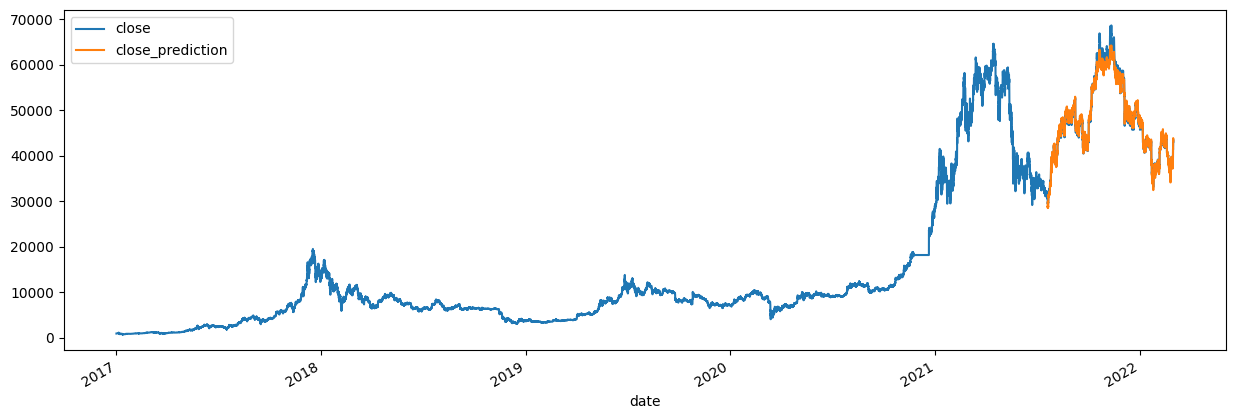

In [ ]:
_ = data_all[['close','close_prediction']].plot(figsize=(15, 5))

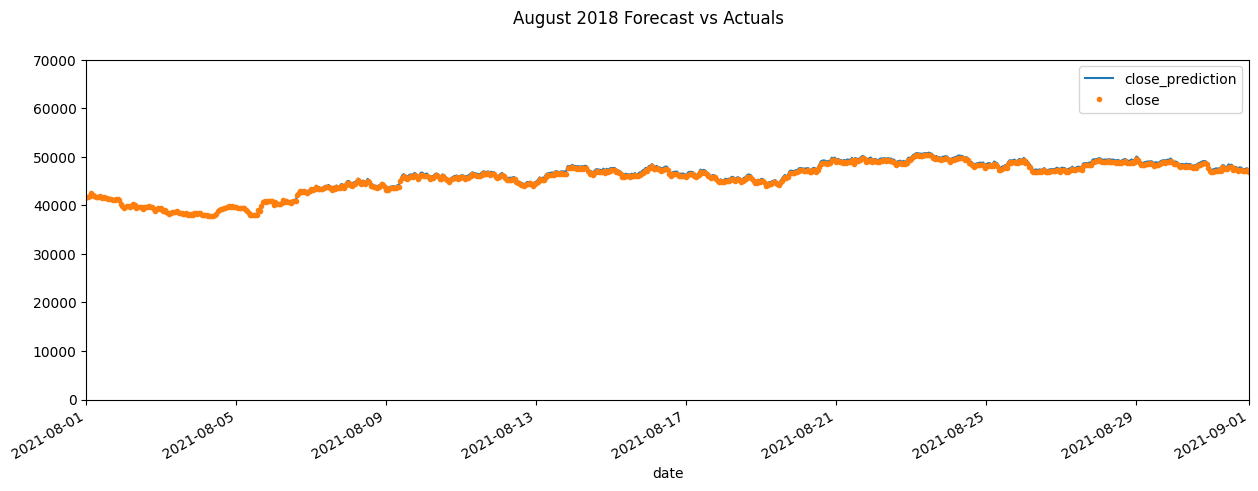

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['close_prediction','close']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='08-01-2021', upper='09-01-2021')
ax.set_ylim(0, 70000)
plot = plt.suptitle('August 2018 Forecast vs Actuals')

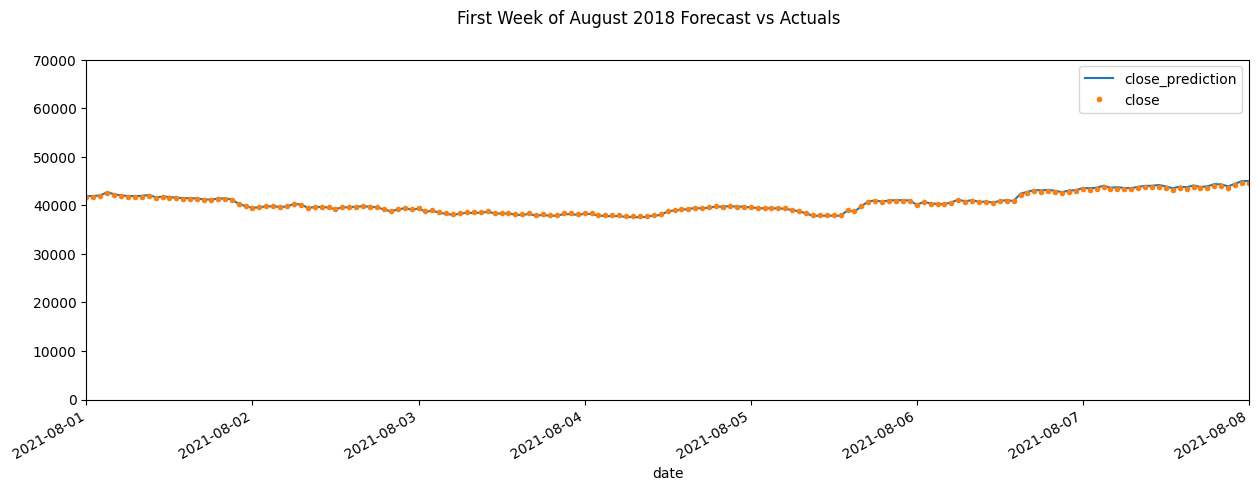

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['close_prediction','close']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='08-01-2021', upper='08-08-2021')
ax.set_ylim(0, 70000)
plot = plt.suptitle('First Week of August 2018 Forecast vs Actuals')

In [ ]:
#calculate MSE and MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error
= mean_squared_error(y_true=data_test['close'],
                   y_pred=data_test['close_prediction'])

mae = mean_absolute_error(y_true=data_test['close'],
                   y_pred=data_test['close_prediction'])

print("RMSE = %s" % (rmse)) # dovresti considerare il valore di RMSE in relazione al range dei valori target nel tuo problema specifico
print("R2 = %s" % (r2)) # piú é vicino ad 1 meglio é
print("MAE = %s" % (mae)) # può essere utile confrontare il valore di MAE con quello di altri modelli o con il range dei valori target per valutare la sua precisione
print("MAPE = %s" % (mape)) # di solito viene utilizzato come misura relativa per confrontare la precisione di modelli diversi
print("ADJ R2 = %s" % (adj_r2)) # piú é vicino ad 1 meglio é

769368.1511175948

577.1765881204685

We can clearly see the entire model is over-fitted.



###   ARIMA ❗


Time Series forecasting using ARIMA

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a class of model that captures a suite of different standard temporal structures in time series data. This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.
ARIMA is one of the mostly used techniques for Time Series analysis. In Python, ARIMA based forecasting models can be created either using AutoARIMA(Pyramid ARIMA) or StatsModel . Here we will be using StatsModel as Kaggle do not support Pyramid ARIMA till now.

In [ ]:
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product

In previous sections of LSTM,XGBoost and Prophet, we used hourly data to train the model. But here we will use the monthly data (for Seasonality).



In [ ]:
data['date'] = data['date'].dt.tz_localize(None)
data = data.groupby([pd.Grouper(key='date', freq='M')]).first().reset_index()
data = data.set_index('date')
data = data[['close']]
data['close'].fillna(method='ffill', inplace=True)

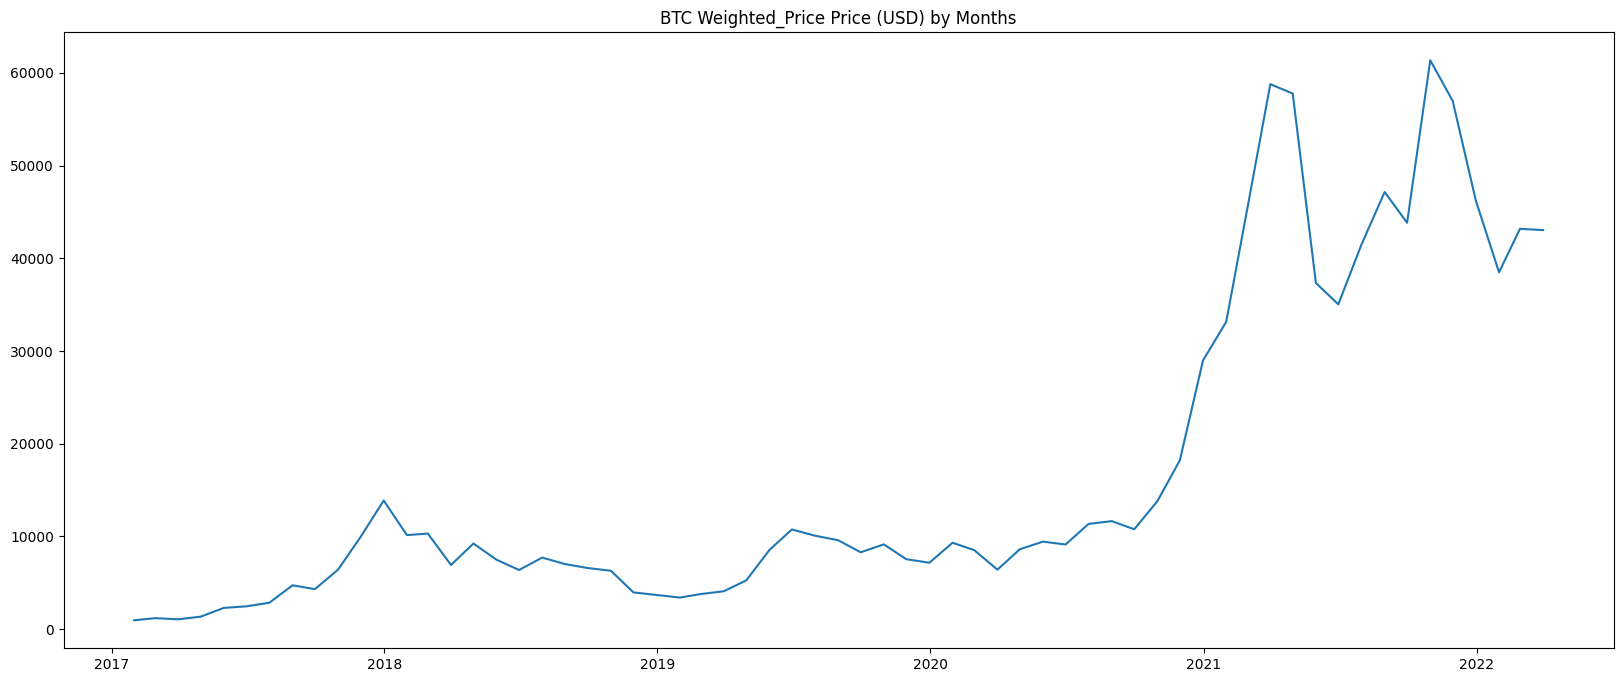

In [ ]:
plt.figure(figsize=[20,8])
plt.title('BTC Weighted_Price Price (USD) by Months')
plt.plot(data.close, '-', label='By Months')

Decomposition

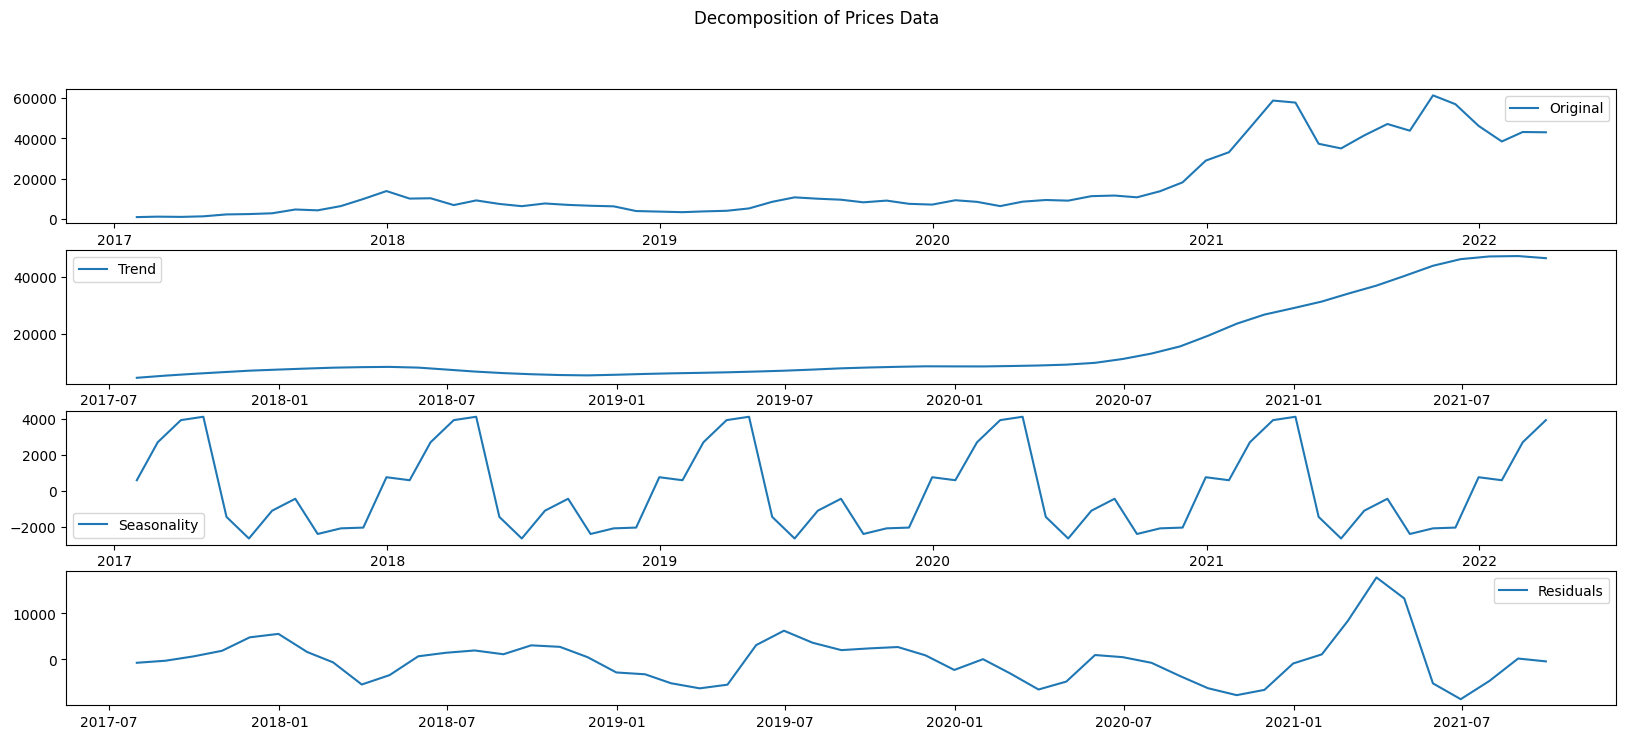

In [ ]:
decomposition = sm.tsa.seasonal_decompose(data.close)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = plt.figure(figsize=(20,8))

plt.subplot(411)
plt.plot(data.close, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

fig.suptitle('Decomposition of Prices Data')
plt.show()

In [ ]:
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(data.close)[1])


Dickey–Fuller test: p=0.895978


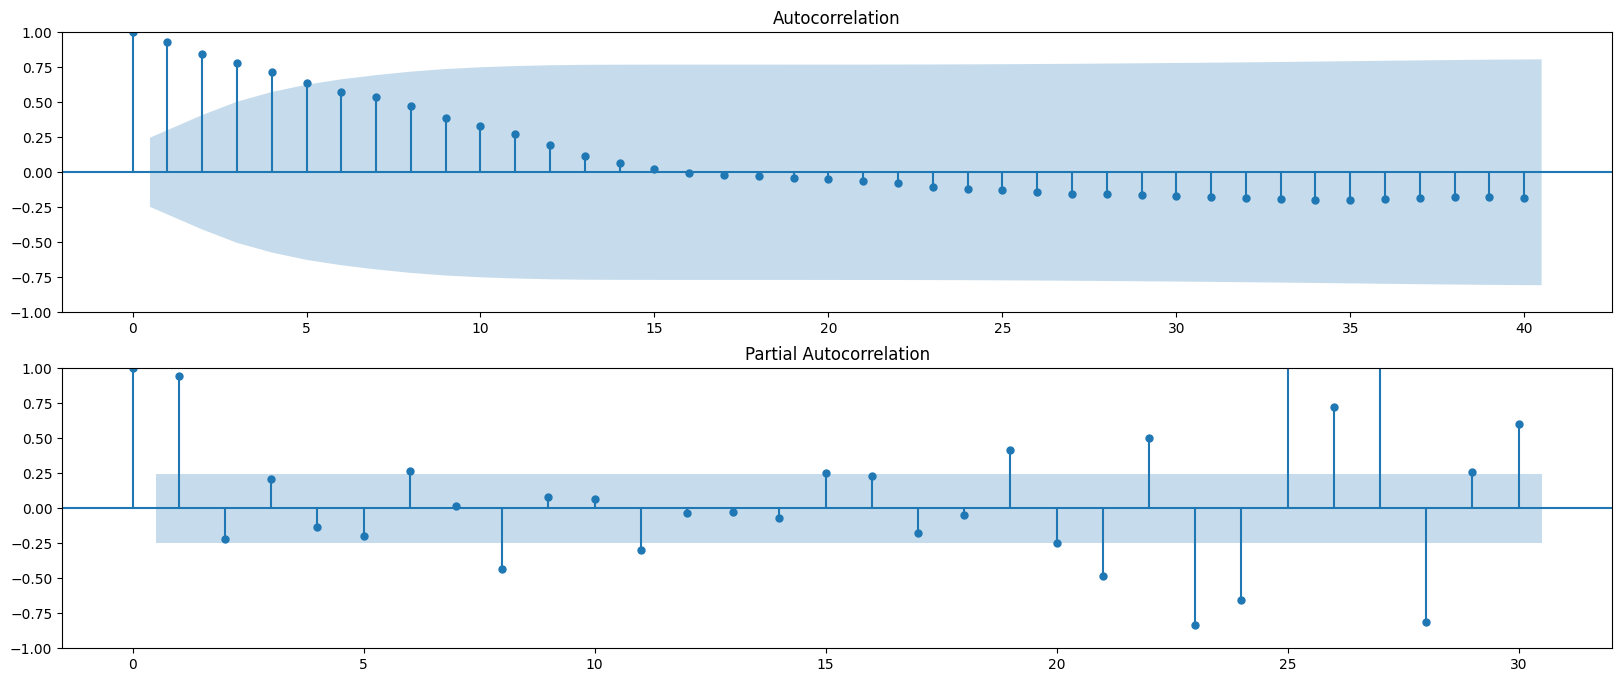

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
pyplot.figure(figsize=(20,8))
pyplot.subplot(211)
plot_acf(data.close, ax=pyplot.gca(),lags=40)
pyplot.subplot(212)
plot_pacf(data.close, ax=pyplot.gca(), lags=30)
pyplot.show()

Here's the Statespace ARIMA Model, the best model is selected using different parameters.



In [ ]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(data.close, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12),enforce_stationarity=False,
                                            enforce_invertibility=False).fit(disp=-1)
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])


In [ ]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
52  (2, 2, 2, 0)  503.964140
53  (2, 2, 2, 1)  504.664639
40  (2, 0, 2, 0)  505.456588
41  (2, 0, 2, 1)  506.774919
47  (2, 1, 2, 1)  508.597269
                                      SARIMAX Results                                      
Dep. Variable:                               close   No. Observations:                   63
Model:             SARIMAX(2, 1, 2)x(2, 1, [], 12)   Log Likelihood                -244.982
Date:                             Tue, 23 May 2023   AIC                            503.964
Time:                                     08:25:36   BIC                            512.211
Sample:                                 01-31-2017   HQIC                           506.152
                                      - 03-31-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------

Dickey–Fuller test:: p=0.200338


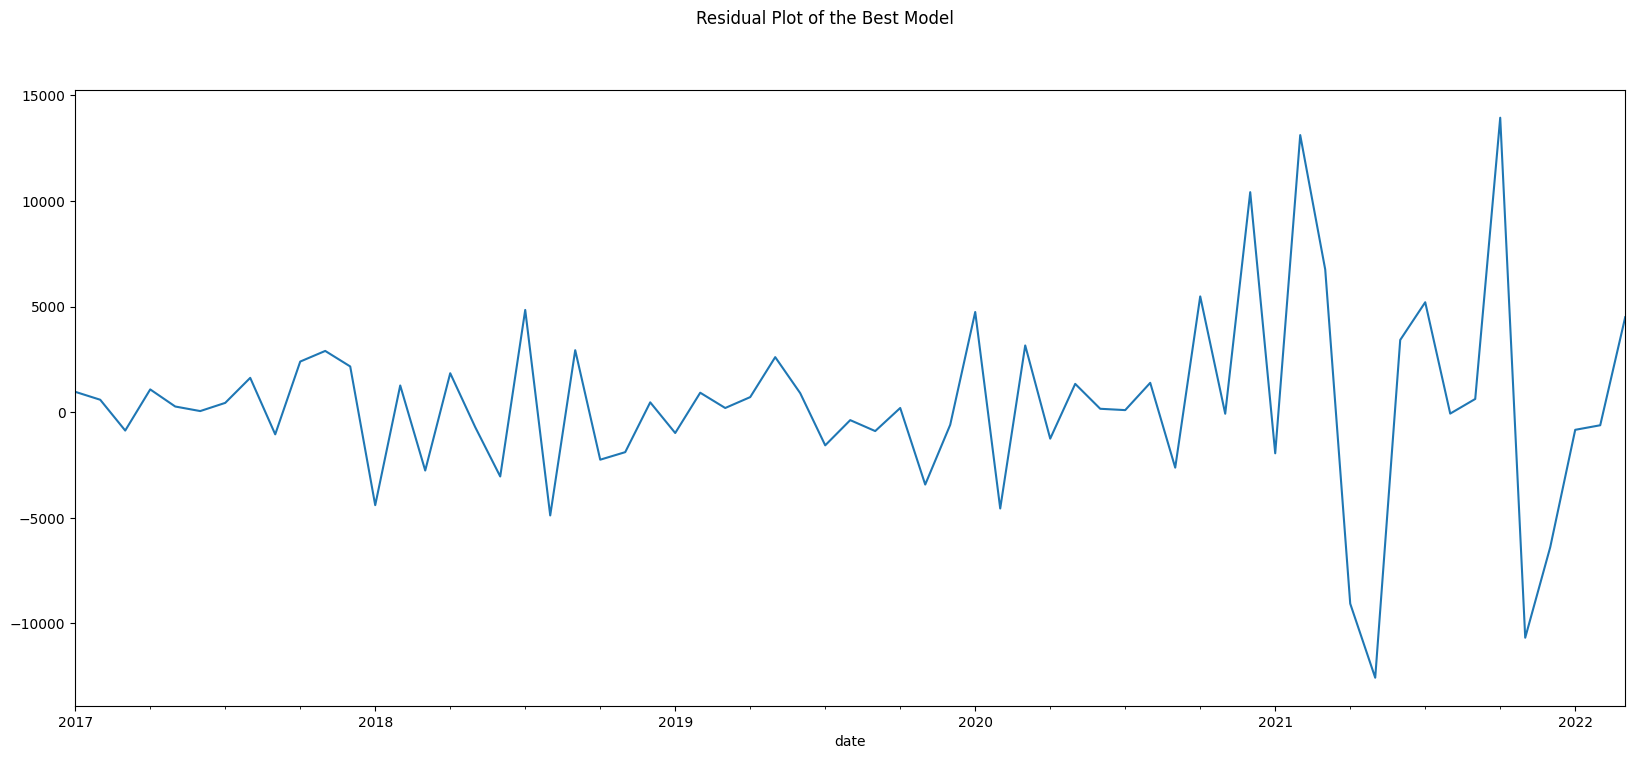

In [ ]:
fig = plt.figure(figsize=(20,8))
best_model.resid.plot()
fig.suptitle('Residual Plot of the Best Model')
print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])

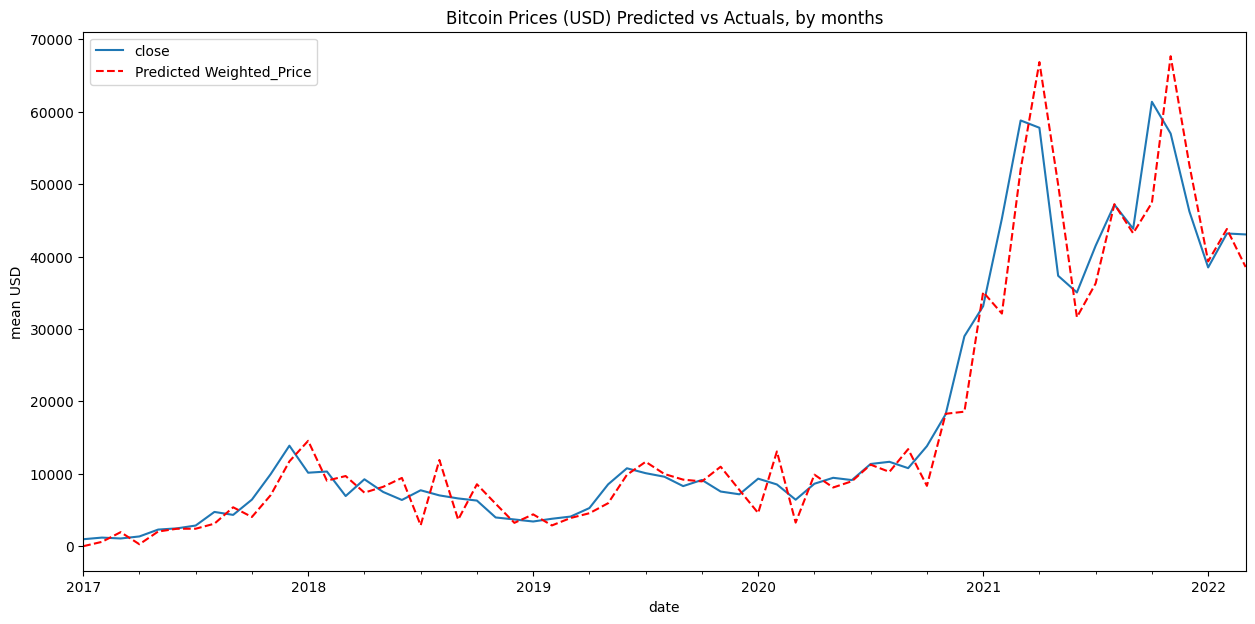

In [ ]:
df_month2 = data[['close']]
future = pd.DataFrame()
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = best_model.predict(start=0, end=200)
plt.figure(figsize=(15,7))
df_month2.close.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('Bitcoin Prices (USD) Predicted vs Actuals, by months')
plt.ylabel('mean USD')
plt.show()


# 5. Conclusions ❗

Here lets visualize and compare the predictive results of LSTM, XGBoost and Prophet in a single plot,

[Text(0.5, 1.0, 'Recall score')]

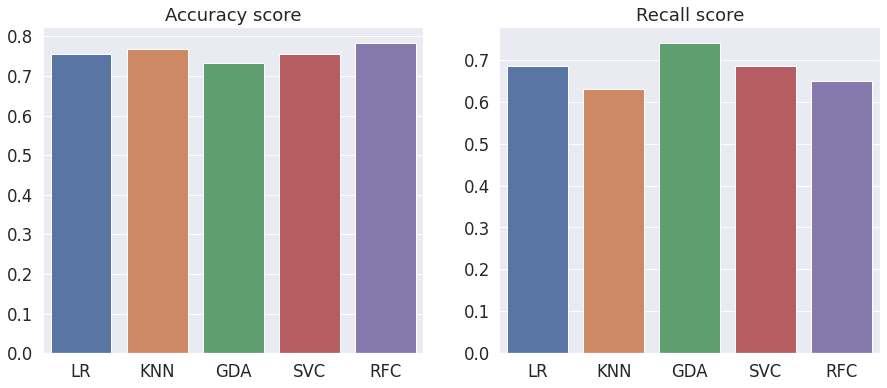

In [ ]:
# Create traces
trace0 = go.Scatter(
    x = final_data['Timestamp'],
    y = final_data['Weighted_Price'],
    mode = 'lines+markers',
    name = 'Real Price'
)
trace1 = go.Scatter(
    x = final_data['Timestamp'],
    y = final_data['lstm'],
    mode = 'lines+markers',
    name = 'LSTM Prediction'
)
trace2 = go.Scatter(
    x = final_data['Timestamp'],
    y = final_data['xgboost'],
    mode = 'lines+markers',
    name = 'XGBoost Prediction'
)
trace3 = go.Scatter(
    x = final_data['Timestamp'],
    y = final_data['prophet'],
    mode = 'lines+markers',
    name = 'Prophet Prediction'
)

# Edit the layout
layout = dict(title = 'Comparision of LSTM,XGBoost and Prophet',
              xaxis = dict(title = 'Month'),
              yaxis = dict(title = 'Prices (USD)'),
              )

data = [trace0, trace1, trace2, trace3]
fig = dict(data=data, layout=layout)
iplot(fig, filename='styled-line')


We can see how the above models perform with Historic Bitcoin Price data. The prediction is not good. The Bitcoin prices are very volatile and very random, and is often influenced by external factors (or news) such as Cryptocurrency regulations, Investments or simple rumours on social media. We need additional data from news or social media to make these models perform better and more accurately.